In [57]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import torch
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [2]:
model = torch.load("/home/dalai/GNN_E/data/results/GAT/balanced/14/all_emo/2406-1002/full_model.pth")

model =  model.to("cpu") #(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print(model)
print(model.gat)


GATModel(
  (gat): GATConv(11, 13, heads=13)
  (fc): Linear(in_features=13, out_features=13, bias=True)
)
GATConv(11, 13, heads=13)


In [3]:
# Number of nodes in the clique
num_nodes = 40

# Create a complete graph with all possible edges (including self-loops)
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()

# Add self-loops to the graph (optional, as some graph representations like complete graphs might not have self-loops)
edge_index = torch.cat([edge_index, torch.stack([torch.arange(num_nodes), torch.arange(num_nodes)])], dim=1)

# Create the node feature tensor, with each node having a feature vector of 1's
x = torch.ones((num_nodes, 11))  # 1-dimensional feature with value 1 for each node
x = torch.rand((num_nodes, 11)) * 10

# Create the edge attribute tensor, with each edge having an attribute of 1
edge_attr = torch.ones((edge_index.size(1), 1))  # 1-dimensional edge attribute for each edge
edge_attr = torch.rand((edge_index.size(1), 1)) * 10

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Print the details of the created graph
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge attribute shape: {data.edge_attr.shape}")

Number of nodes: 40
Number of edges: 820
Node feature shape: torch.Size([40, 11])
Edge index shape: torch.Size([2, 820])
Edge attribute shape: torch.Size([820, 1])


In [4]:
edge_index, attention_weights = model.get_attention_weights(data)
edge_index = edge_index.detach().numpy()
print(edge_index.shape)
attention_weights = attention_weights.detach().numpy() 
print(attention_weights.shape)

(2, 820)
(820, 13)


In [5]:
attention_weights

array([[6.96790516e-01, 4.32065606e-01, 9.31524575e-01, ...,
        4.97871965e-01, 3.86515051e-01, 9.43486273e-01],
       [2.59298980e-01, 2.43500501e-01, 9.11297858e-01, ...,
        2.81545162e-01, 2.09851384e-01, 9.38670158e-01],
       [1.67419627e-01, 1.84129119e-01, 8.63475621e-01, ...,
        2.15656191e-01, 1.42713740e-01, 8.89524162e-01],
       ...,
       [9.33964085e-03, 1.47696584e-02, 1.42588187e-02, ...,
        2.22550556e-02, 2.04759240e-02, 2.11045332e-02],
       [8.11584687e-05, 1.38544813e-02, 5.93375899e-02, ...,
        1.63220949e-02, 1.03792995e-02, 4.30083424e-02],
       [1.19542086e-03, 2.80295685e-02, 1.63421896e-03, ...,
        2.22379789e-02, 2.26229001e-02, 9.63818573e-04]], dtype=float32)

In [6]:
def attention_to_adj_matrix(attention_weights, edge_index, num_nodes):
    """
    Convert attention weights and edge indices into an adjacency matrix.
    
    Args:
        attention_weights (Tensor): Attention weights of shape (num_edges, num_heads).
        edge_index (Tensor): Edge indices of shape (2, num_edges).
        num_nodes (int): Number of nodes in the graph.
        
    Returns:
        adj_matrices (Tensor): Adjacency matrices for each head of shape (num_heads, num_nodes, num_nodes).
    """
    num_edges, num_heads = attention_weights.shape  # attention_weights is (num_edges, num_heads)
    adj_matrices = np.zeros((num_heads, num_nodes, num_nodes))  # Initialize the adjacency matrices

    # Populate adjacency matrices for each head
    for head in range(num_heads):
        for i in tqdm(range(num_edges), desc=f"Processing head {head}"):
            src, dst = edge_index[:, i]  # Get the source and destination nodes for each edge
            adj_matrices[head, src, dst] = attention_weights[i, head]  # Set the attention weight for this edge

            # Optionally, if the graph is undirected, also set the reverse direction:
            adj_matrices[head, dst, src] = attention_weights[i, head]
            
    return adj_matrices

adj_matrices = attention_to_adj_matrix(attention_weights, edge_index, num_nodes)


Processing head 12: 100%|██████████| 820/820 [00:00<00:00, 521347.47it/s]


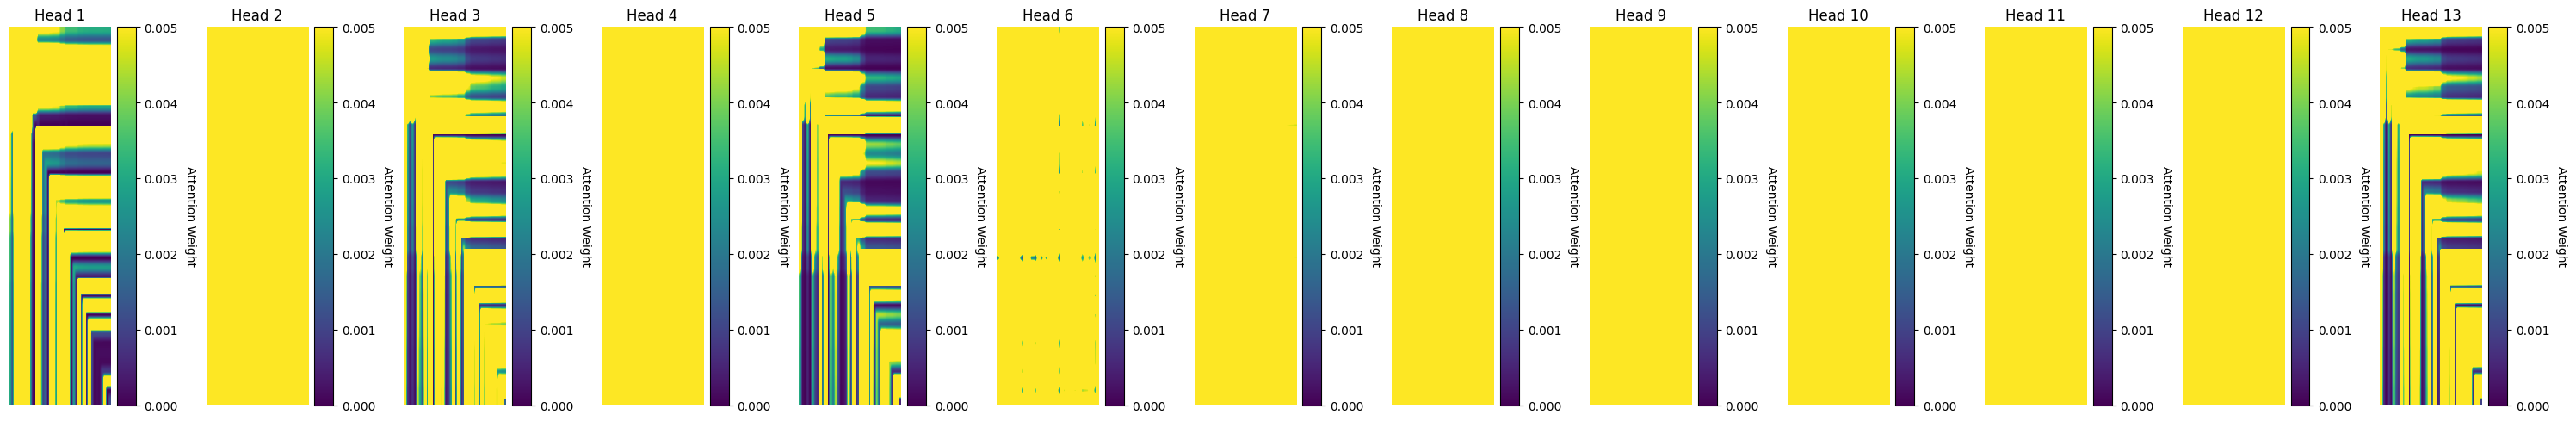

In [7]:
def plot_adj_matrices(adj_matrices):
    """
    Plot adjacency matrices for each attention head as heatmaps with the same colormap and colorbar range.
    
    Args:
        adj_matrices (Tensor or np.ndarray): Adjacency matrices of shape (num_heads, num_nodes, num_nodes).
    """
    # Ensure the input is a NumPy array
    if isinstance(adj_matrices, np.ndarray):
        pass
    elif hasattr(adj_matrices, 'cpu'):  # If it's a PyTorch tensor
        adj_matrices = adj_matrices.detach().cpu().numpy()
    else:
        raise TypeError("adj_matrices should be either a numpy array or a PyTorch tensor.")
    
    num_heads = adj_matrices.shape[0]
    
    # Set a global vmin and vmax for the color range
    vmin = 0
    vmax = 0.005
    
    # Create the figure with dynamic sizing based on the number of heads
    plt.figure(figsize=(min(5 * num_heads, 30), 5))  # Adjust width per head, max width of 30

    for head in range(num_heads):
        plt.subplot(1, num_heads, head + 1)
        
        # Display the heatmap with a fixed colormap and color scale
        im = plt.imshow(adj_matrices[head][:200,:100], cmap="viridis", aspect="auto", vmin=vmin, vmax=vmax)
        
        # Add a colorbar with the same range
        cbar = plt.colorbar(im)
        cbar.set_label('Attention Weight', rotation=270, labelpad=15)
        
        plt.title(f"Head {head + 1}")
        plt.axis("off")  # Hide the axes for a cleaner look
        
    
    # Adjust the layout for better spacing and visualization
    plt.tight_layout()  
    plt.show()

# Example usage
plot_adj_matrices(adj_matrices)

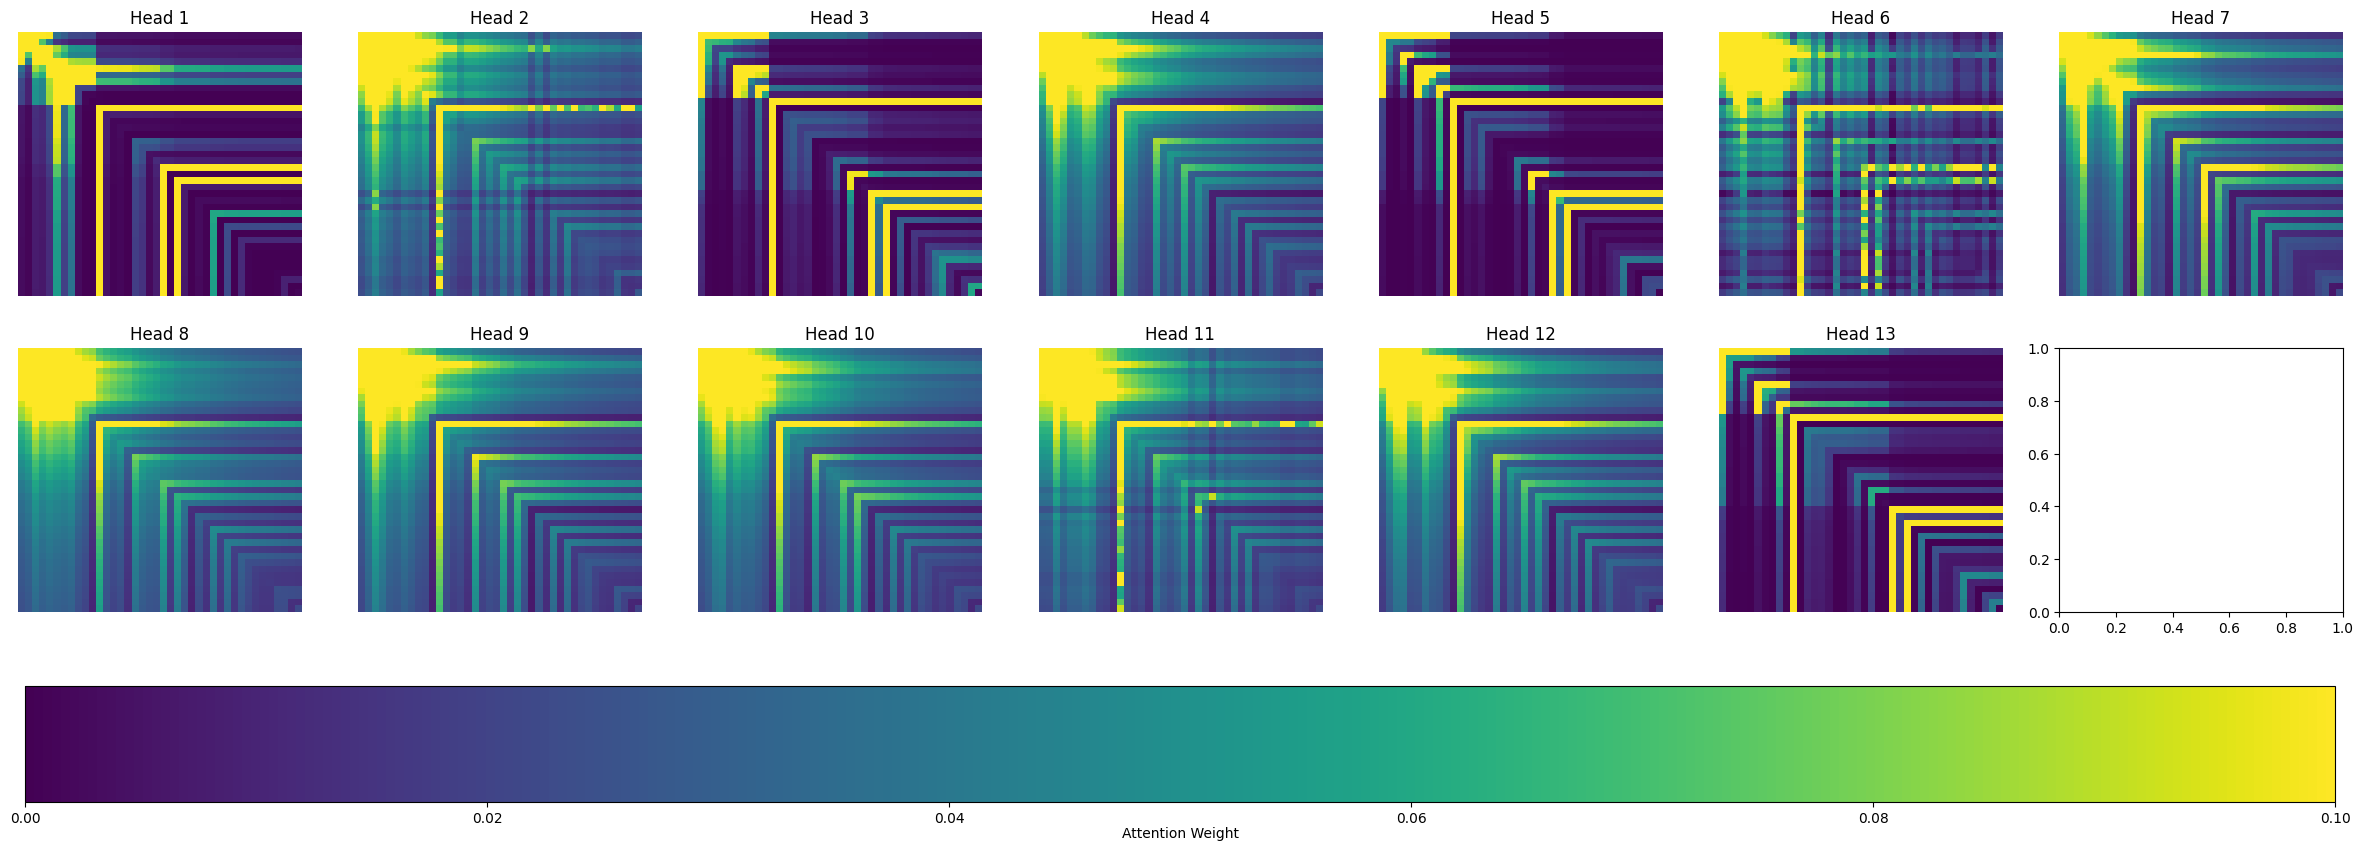

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_adj_matrices(adj_matrices):
    """
    Plot adjacency matrices for each attention head as heatmaps with the same colormap and colorbar range, 
    and plot the colorbar only once. The plots will be arranged in 2 rows.
    
    Args:
        adj_matrices (Tensor or np.ndarray): Adjacency matrices of shape (num_heads, num_nodes, num_nodes).
    """
    # Ensure the input is a NumPy array
    if isinstance(adj_matrices, np.ndarray):
        pass
    elif hasattr(adj_matrices, 'cpu'):  # If it's a PyTorch tensor
        adj_matrices = adj_matrices.detach().cpu().numpy()
    else:
        raise TypeError("adj_matrices should be either a numpy array or a PyTorch tensor.")
    
    num_heads = adj_matrices.shape[0]
    
    # Set a global vmin and vmax for the color range
    vmin = 0
    vmax = 0.1
    
    # Calculate the number of columns based on the number of heads
    num_cols = (num_heads + 1) // 2  # Number of columns to ensure 2 rows
    
    # Create the figure with 2 rows and dynamic columns based on the number of heads
    fig, axes = plt.subplots(2, num_cols, figsize=(min(5 * num_cols, 30), 10))  # Adjust width per column, max width of 30

    for head in range(num_heads):
        row = head // num_cols  # Row index for 2 rows
        col = head % num_cols   # Column index based on the number of columns
        ax = axes[row, col]  # Select the appropriate subplot
        
        # Display the heatmap with a fixed colormap and color scale
        im = ax.imshow(adj_matrices[head], cmap="viridis", aspect="auto", vmin=vmin, vmax=vmax)
        
        ax.set_title(f"Head {head + 1}")
        ax.axis("off")  # Hide the axes for a cleaner look

    # Add a single colorbar that spans all plots
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.1)
    cbar.set_label('Attention Weight', rotation=0, labelpad=10)
    
    # Manually adjust layout to ensure colorbar and plots don't overlap
    fig.subplots_adjust(bottom=0.3)  # Adjust the bottom margin to fit the colorbar
    
    plt.show()

# Example usage
plot_adj_matrices(adj_matrices)


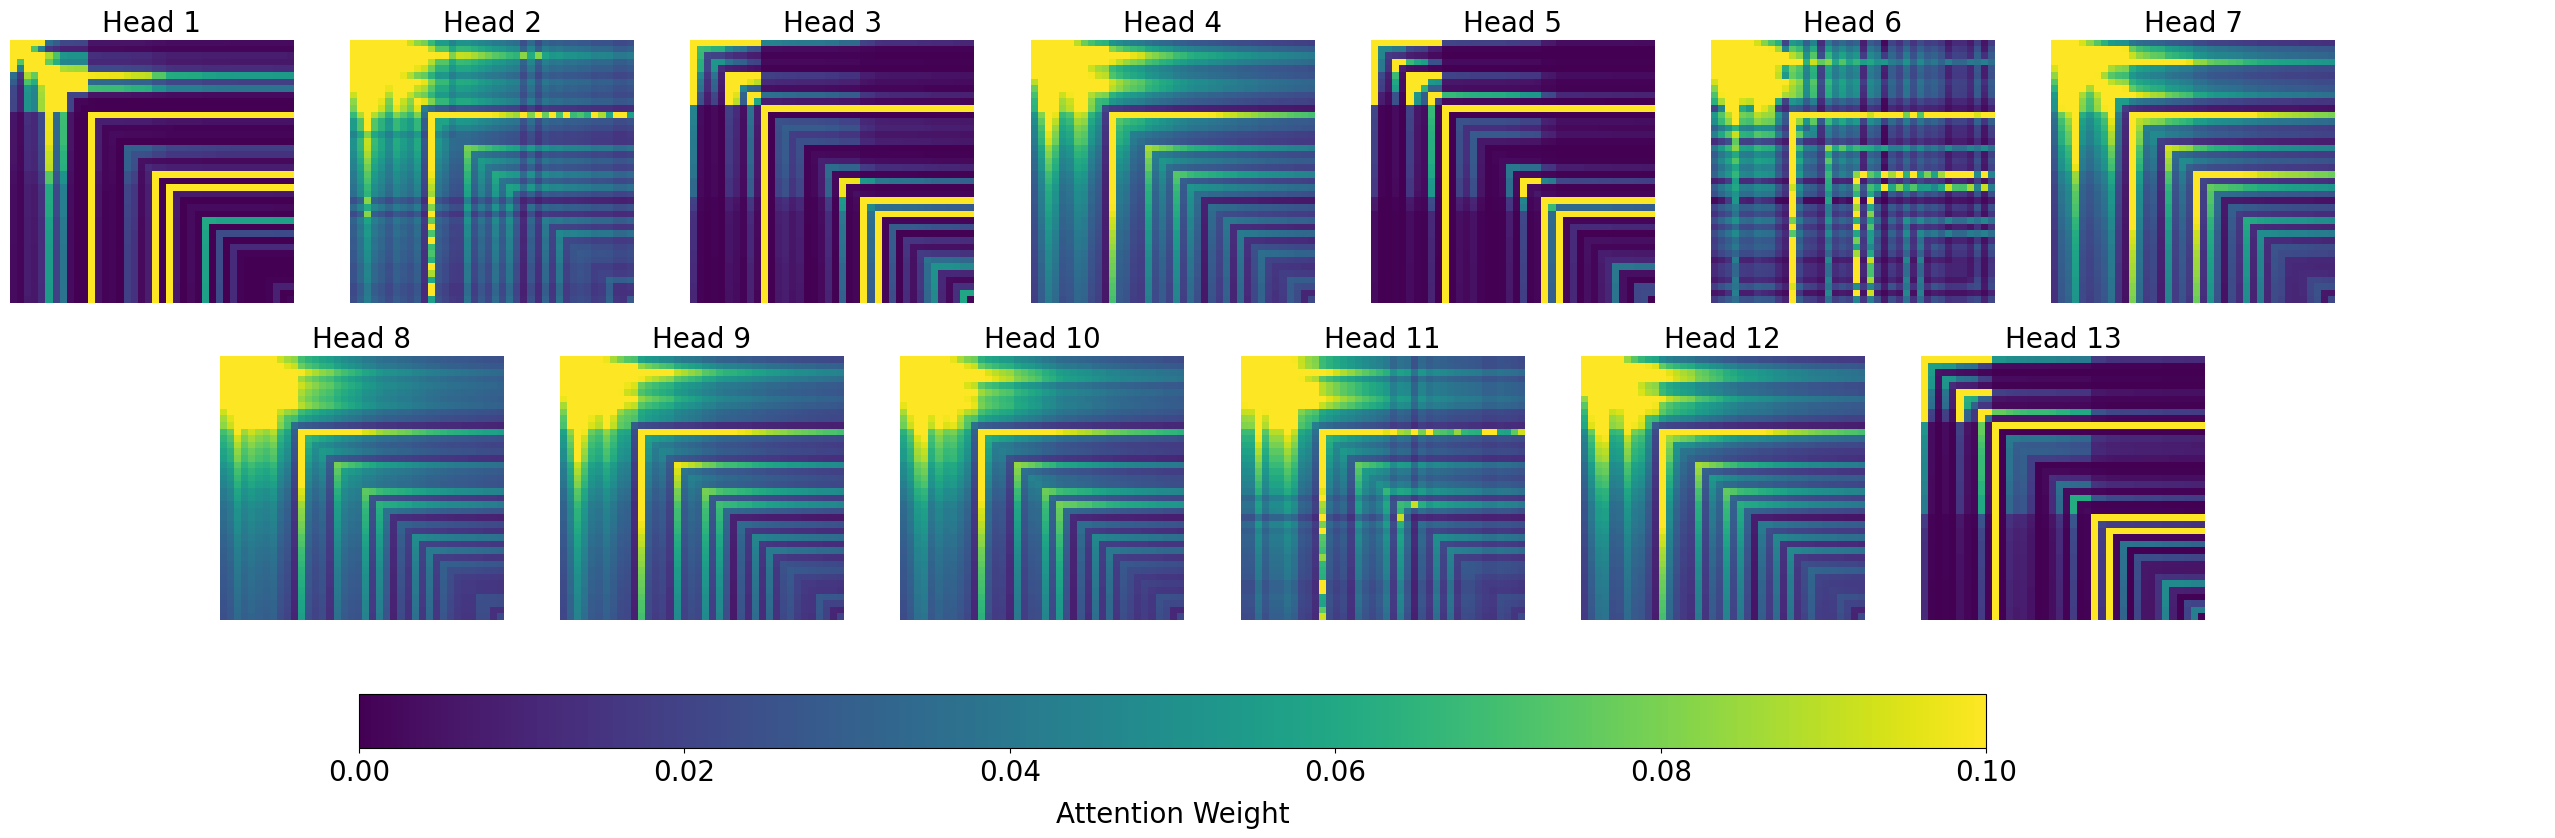

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_adj_matrices(adj_matrices):
    """
    Plot adjacency matrices for each attention head as heatmaps with the same colormap and colorbar range, 
    and plot the colorbar only once. The plots will be arranged in 2 rows, with the second row centered.
    
    Args:
        adj_matrices (Tensor or np.ndarray): Adjacency matrices of shape (num_heads, num_nodes, num_nodes).
    """
    # Ensure the input is a NumPy array
    if isinstance(adj_matrices, np.ndarray):
        pass
    elif hasattr(adj_matrices, 'cpu'):  # If it's a PyTorch tensor
        adj_matrices = adj_matrices.detach().cpu().numpy()
    else:
        raise TypeError("adj_matrices should be either a numpy array or a PyTorch tensor.")
    
    num_heads = adj_matrices.shape[0]
    
    # Set a global vmin and vmax for the color range
    vmin = 0
    vmax = 0.1
    
    # Fixed number of rows and columns
    num_cols = 7  # We have 7 columns in total for the 2 rows
    num_rows = 2  # 2 rows total (fixed)
    
    # Create the figure with a grid of 2 rows and 7 columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(min(5 * num_cols, 30), 10))  # Adjusted size
    
    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Loop over the plots and fill in the heatmaps
    for head in range(num_heads):
        ax = axes[head]  # Select the appropriate subplot
        
        # Display the heatmap with a fixed colormap and color scale
        im = ax.imshow(adj_matrices[head], cmap="viridis", aspect="auto", vmin=vmin, vmax=vmax)
        
        ax.set_title(f"Head {head + 1}", fontsize=20)
        ax.axis("off")  # Hide axes for cleaner appearance

    # Hide empty subplots in the second row (if there are fewer than 7 plots in the second row)
    for idx in range(num_heads, len(axes)):
        axes[idx].axis("off")
    
    # Add a single colorbar that spans all plots
    cbar = fig.colorbar(im, ax=axes.tolist(), orientation='horizontal', pad=0, shrink=0.7, aspect=30)
    cbar.set_label('Attention Weight', rotation=0, labelpad=10, fontsize=20)
    
    # Adjust the layout to prevent overlap and ensure colorbar fits
    cbar.ax.tick_params(labelsize=20) 
    fig.subplots_adjust(bottom=0.3)  # Move the colorbar further down
    
    # Center the second row by adjusting the position of the axes
    for ax in axes[7:]:
        ax.set_position(ax.get_position().translated(0.07, 0))  # Adjust position to center them

    plt.show()

# Example usage
plot_adj_matrices(adj_matrices)


# Plot Correlation Matrix

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import torch
import os
os.chdir("/home/dalai/GNN_E")
print(os.getcwd())

import sys
scripts_path = os.getcwd()
print(scripts_path)
sys.path.append(scripts_path)

from utils_models import *

from math import ceil
import pandas as pd
import argparse
from types import SimpleNamespace
import json
from contextlib import redirect_stdout
from pathlib import Path
import matplotlib.pyplot as plt
import random

import torch
import torch.optim as optim


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/dalai/GNN_E
/home/dalai/GNN_E


In [80]:
df_all_movies = pd.read_csv(f"data/processed/all_movies_labelled_13_single_balanced.csv")
df_all_movies = df_all_movies[df_all_movies.movie.isin([13])]


In [82]:
df_train, df_test = split_train_test_vertically(
    df_all_movies, 
    #test_movies_dict = {"FirstBite": 4, "Superhero": 9, "YouAgain": 13})
    test_movies_dict = {"FirstBite": 4, "YouAgain": 13})
df_val = df_train[df_train.id == 99] #make sure to be empty
df_test

,Unnamed: 0.1,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
109315872,109315872,109315872,0,7.069645,1,13,0,-1
109315873,109315873,109315873,0,6.719067,1,13,1,-1
109315874,109315874,109315874,0,1.596613,1,13,2,-1
109315875,109315875,109315875,0,-5.593789,1,13,3,-1
109315876,109315876,109315876,0,29.112240,1,13,4,-1
...,...,...,...,...,...,...,...,...
118876369,118876369,118876369,413,-21.945122,32,13,763,-1
118876370,118876370,118876370,413,3.040432,32,13,764,-1
118876371,118876371,118876371,413,-36.525375,32,13,765,-1
118876372,118876372,118876372,413,-7.233601,32,13,766,-1


Movies in this df: [9]


Processing 9 9:   0%|          | 0/393 [00:00<?, ?timepoint/s]

(414, 414)
True
171396


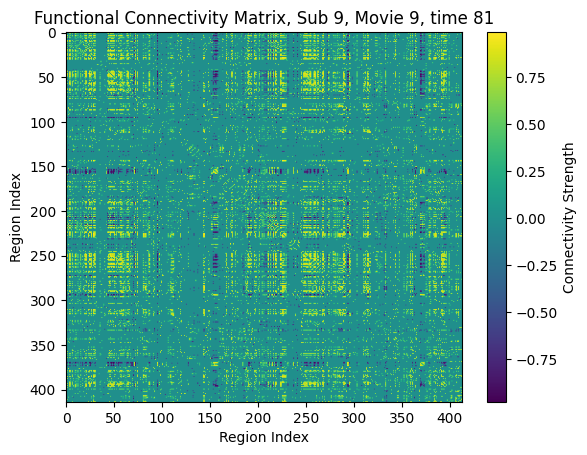

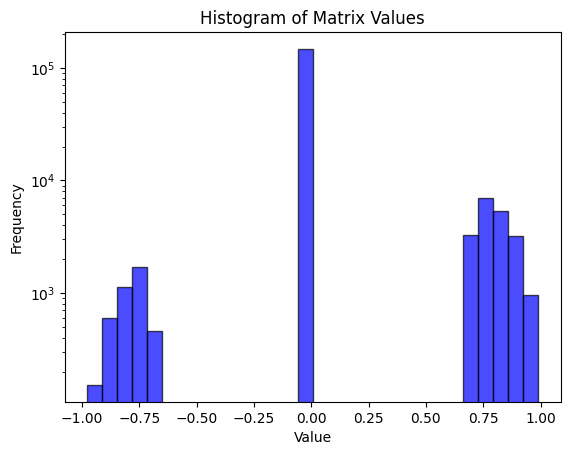

Processing 9 9:   0%|          | 1/393 [00:02<14:28,  2.22s/timepoint]


KeyboardInterrupt: 

In [47]:
dataset_train = DatasetEmo(
    df = df_train, #df with mvoies to use
    node_feat = "symmetricwindow", #"singlefmri", "symmetricwindow", "pastwindow"
    initial_adj_method = "clique_edgeAttr_FC_window", #"clique_edgeAttr_FC_window", #"FN_edgeAttr_FC_window",
        # "clique"
        #FC dynamic:  "fcmovie", "fcwindow"
        #FN (subcorticla with clique): "FN_const" "FN_edgeAttr_FC_window" "FN_edgeAttr_FC_movie"
    FN = 'Vis',  #['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default' 'Sub']
    FN_paths = "data/raw/FN_raw",
    sizewind = 5,
    verbose = True,
    thr_FC = 0.7 #big windows requires smoaller thr
)

In [ ]:

d = dataset_train.get_graphs_list()
d[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data(x=[414, 11], edge_index=[2, 1560], edge_attr=[1560], y=7)

In [66]:
np.arange(2,3)


array([2])

<Axes: ylabel='Frequency'>

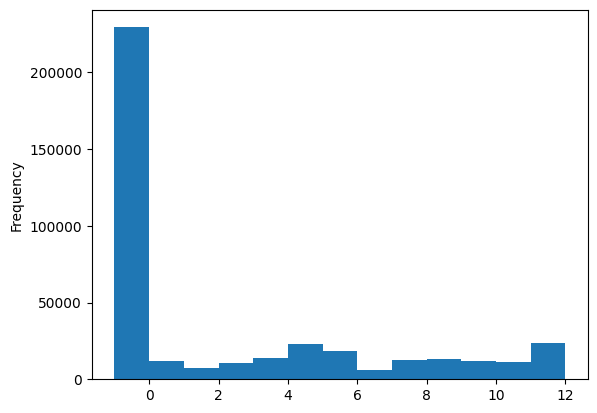

In [62]:
df_train.loc[((df_train.id.isin(np.arange(1, 10)))), "label"].plot(kind="hist", bins=13)

In [74]:
df_train.loc[((df_train.id == 9) & (df_train.movie == 13) & (df_train.timestamp_tr == 500)), "label"] 

Series([], Name: label, dtype: int64)

<Axes: ylabel='Frequency'>

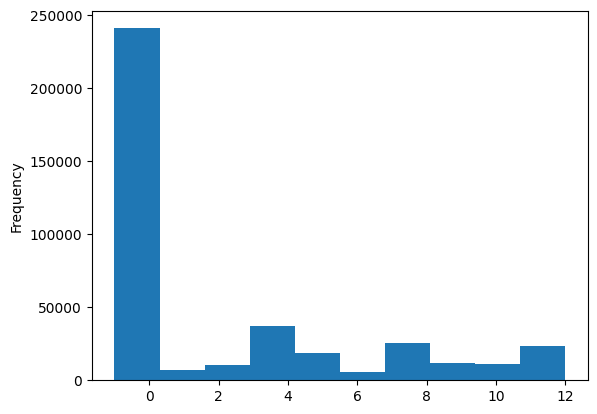

In [79]:
df_train.loc[((df_train.id == 9) & (df_train.movie == 9)), "label"].plot(kind="hist")

In [89]:
df_test.loc[((df_test.id == 10) & (df_test.movie == 13) & (df_test.timestamp_tr == 100)), "label"]


112182094    1
112182863    1
112183632    1
112184401    1
112185170    1
            ..
112496615    1
112497384    1
112498153    1
112498922    1
112499691    1
Name: label, Length: 414, dtype: int64